In [1]:
# Import library
import pandas as pd
import numpy as np
import os, random, warnings, gc, psutil
from tqdm import tqdm_notebook

from multiprocessing import Pool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from catboost import CatBoostRegressor

from math import sqrt

import lightgbm as lgbm

from glob import glob
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Set options
pd.set_option('max_columns',500)
pd.set_option('max_rows',500)
pd.options.display.max_colwidth = 300

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_palette('bright')

In [2]:
SEED = 1993
n_splits= 5

NUM_BOOST_ROUND = 10000
lgbm_param = {'objective':'binary',
              'metric':'binary_logloss',
              'boosting_type': 'gbdt',
              'random_state':SEED,
              'learning_rate':0.01,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.6,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
#               'reg_lambda':5,
#               'reg_alpha': 7,
#                'num_leaves': 64,
            }

In [3]:
# 02에서 만든 피쳐들을 모두 결합한 pickle파일입니다. 
train = pd.read_pickle('./input/game-bot/train.pickle')
test = pd.read_pickle('./input/game-bot/test.pickle')

In [4]:
train_set = train.drop('class',1)
train_label = train['class']
test_set  = test.copy()

In [5]:
drop_cols = ['sum_gather','p_s_out_deg','Reborn_per_day_count','mean','playtime','Exp_repair_count_x','avg(Killed_bypc_per_day_count)',
                'count_donepoll']

drop_cols = []

In [6]:
train_set = train_set.drop(drop_cols, 1)
test_set = test_set.drop(drop_cols, 1)

## LGBM

In [7]:
cv_list = []

lgbm_final_oof_train = np.zeros( train.shape[0] )
lgbm_final_oof_test = np.zeros( test.shape[0] )

n_seeds = 5

for _ in tqdm_notebook( range(n_seeds) ):
    seed = np.random.randint(10000)

    oof_train = np.zeros( train.shape[0] )
    final_test = np.zeros( test.shape[0] )

    kfolds = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate(kfolds.split(X= train_set, y = train_label)) ):

        X_train, y_train = train_set.iloc[trn_ind], train_label[trn_ind]
        X_valid, y_valid = train_set.iloc[val_ind], train_label[val_ind]

        dtrain = lgbm.Dataset( X_train, y_train )
        dvalid = lgbm.Dataset( X_valid, y_valid ,reference=dtrain)

        model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, valid_sets=(dtrain, dvalid), valid_names=('train','valid'), 
                            verbose_eval= 100)

        valid_pred = model.predict(X_valid)
        test_pred  = model.predict(test_set)

        oof_train[val_ind] += valid_pred
        final_test += test_pred

        cv_list.append( roc_auc_score(y_valid, valid_pred) )

        print('='*80)

    final_test /= n_splits
    
    lgbm_final_oof_train += oof_train
    lgbm_final_oof_test += final_test

lgbm_final_oof_train /= n_seeds
lgbm_final_oof_test /= n_seeds

print(f"Average CV : {np.mean(cv_list)}")
print(f"RMSE for OOF: {roc_auc_score(train_label, lgbm_final_oof_train)}")

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0999797	valid's binary_logloss: 0.10515
[200]	train's binary_logloss: 0.0570782	valid's binary_logloss: 0.0797417
[300]	train's binary_logloss: 0.0348236	valid's binary_logloss: 0.0707724
[400]	train's binary_logloss: 0.0223135	valid's binary_logloss: 0.0683102
Early stopping, best iteration is:
[443]	train's binary_logloss: 0.0186079	valid's binary_logloss: 0.0678961
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0946781	valid's binary_logloss: 0.125688
[200]	train's binary_logloss: 0.0542135	valid's binary_logloss: 0.0999263
[300]	train's binary_logloss: 0.0328944	valid's binary_logloss: 0.0914227
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Early stopping, best iteration is:
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Training until validation scores don't improve for 50 rounds
[100]	train'

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0999797	valid's binary_logloss: 0.10515
[200]	train's binary_logloss: 0.0570782	valid's binary_logloss: 0.0797417
[300]	train's binary_logloss: 0.0348236	valid's binary_logloss: 0.0707724
[400]	train's binary_logloss: 0.0223135	valid's binary_logloss: 0.0683102
Early stopping, best iteration is:
[443]	train's binary_logloss: 0.0186079	valid's binary_logloss: 0.0678961
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0946781	valid's binary_logloss: 0.125688
[200]	train's binary_logloss: 0.0542135	valid's binary_logloss: 0.0999263
[300]	train's binary_logloss: 0.0328944	valid's binary_logloss: 0.0914227
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Early stopping, best iteration is:
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Training until validation scores don't improve for 50 rounds
[100]	train'

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0999797	valid's binary_logloss: 0.10515
[200]	train's binary_logloss: 0.0570782	valid's binary_logloss: 0.0797417
[300]	train's binary_logloss: 0.0348236	valid's binary_logloss: 0.0707724
[400]	train's binary_logloss: 0.0223135	valid's binary_logloss: 0.0683102
Early stopping, best iteration is:
[443]	train's binary_logloss: 0.0186079	valid's binary_logloss: 0.0678961
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0946781	valid's binary_logloss: 0.125688
[200]	train's binary_logloss: 0.0542135	valid's binary_logloss: 0.0999263
[300]	train's binary_logloss: 0.0328944	valid's binary_logloss: 0.0914227
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Early stopping, best iteration is:
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Training until validation scores don't improve for 50 rounds
[100]	train'

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0999797	valid's binary_logloss: 0.10515
[200]	train's binary_logloss: 0.0570782	valid's binary_logloss: 0.0797417
[300]	train's binary_logloss: 0.0348236	valid's binary_logloss: 0.0707724
[400]	train's binary_logloss: 0.0223135	valid's binary_logloss: 0.0683102
Early stopping, best iteration is:
[443]	train's binary_logloss: 0.0186079	valid's binary_logloss: 0.0678961
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0946781	valid's binary_logloss: 0.125688
[200]	train's binary_logloss: 0.0542135	valid's binary_logloss: 0.0999263
[300]	train's binary_logloss: 0.0328944	valid's binary_logloss: 0.0914227
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Early stopping, best iteration is:
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Training until validation scores don't improve for 50 rounds
[100]	train'

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0999797	valid's binary_logloss: 0.10515
[200]	train's binary_logloss: 0.0570782	valid's binary_logloss: 0.0797417
[300]	train's binary_logloss: 0.0348236	valid's binary_logloss: 0.0707724
[400]	train's binary_logloss: 0.0223135	valid's binary_logloss: 0.0683102
Early stopping, best iteration is:
[443]	train's binary_logloss: 0.0186079	valid's binary_logloss: 0.0678961
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0946781	valid's binary_logloss: 0.125688
[200]	train's binary_logloss: 0.0542135	valid's binary_logloss: 0.0999263
[300]	train's binary_logloss: 0.0328944	valid's binary_logloss: 0.0914227
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Early stopping, best iteration is:
[400]	train's binary_logloss: 0.020915	valid's binary_logloss: 0.0898772
Training until validation scores don't improve for 50 rounds
[100]	train'

In [8]:
best_threshold_dict = {}
for threshold in np.linspace(0,1, 100) :
    temp_f1_score = f1_score( train_label, [ 1 if x >=threshold else 0 for x in lgbm_final_oof_train ])
    best_threshold_dict[threshold] = temp_f1_score

In [9]:
sorted( best_threshold_dict.items() ,key= lambda x: x[1] ,reverse=True)

[(0.23232323232323235, 0.8601398601398601),
 (0.26262626262626265, 0.8599118942731276),
 (0.24242424242424243, 0.8598949211908933),
 (0.3535353535353536, 0.8597285067873304),
 (0.25252525252525254, 0.859402460456942),
 (0.30303030303030304, 0.8591928251121077),
 (0.3434343434343435, 0.8589511754068716),
 (0.36363636363636365, 0.858695652173913),
 (0.27272727272727276, 0.8584070796460176),
 (0.4444444444444445, 0.8581884720951509),
 (0.31313131313131315, 0.8581687612208259),
 (0.22222222222222224, 0.8581375108790252),
 (0.32323232323232326, 0.8579136690647483),
 (0.4747474747474748, 0.8576675849403121),
 (0.48484848484848486, 0.8576675849403121),
 (0.37373737373737376, 0.85766092475068),
 (0.33333333333333337, 0.8576576576576577),
 (0.2828282828282829, 0.8576512455516015),
 (0.29292929292929293, 0.8573975044563279),
 (0.393939393939394, 0.8571428571428572),
 (0.4545454545454546, 0.8571428571428571),
 (0.21212121212121213, 0.8568950563746748),
 (0.4646464646464647, 0.8568807339449541),
 

In [10]:
df_imp = pd.DataFrame(data = {'col' : model.feature_name(), 
                               'imp' : model.feature_importance()
                              })

df_imp.sort_values(by='imp', ascending=False, inplace=True)

df_imp

,col,imp
7,sum_playtime,466
15,Day_unique_count,405
6,mean_playtime,372
39,avg(Exp_get_per_day_count),368
37,avg(sit_per_day_count),364
73,quest_success_count,325
72,quest_try_count,313
17,max_level_y,306
38,sit_count,293
9,sum_money_x,293


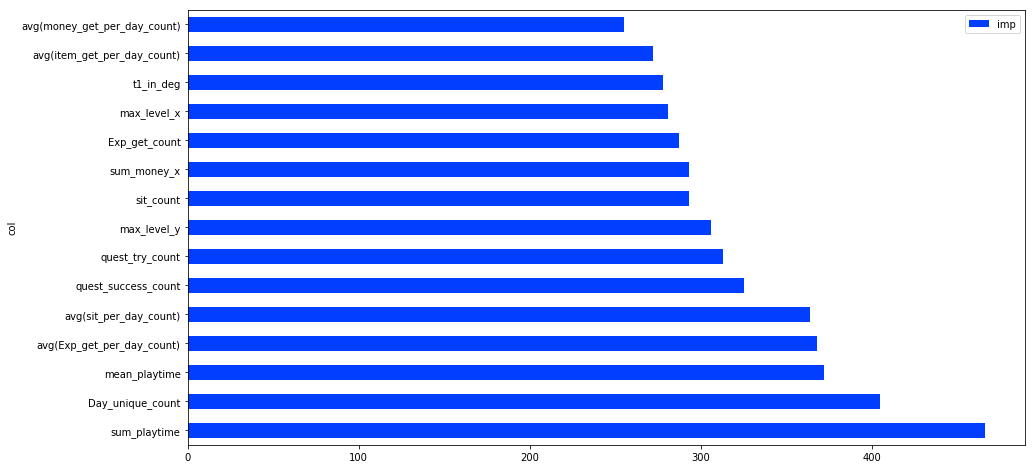

In [11]:
df_imp.head(15).plot.barh(x='col',y='imp', figsize=(15,8))

## CATBOOST

In [12]:
SEED = 1993
n_splits = 5

NUM_BOOST_ROUND = 10000
cat_params = {
        'n_estimators': NUM_BOOST_ROUND,
        'learning_rate': 0.01,
       'eval_metric': 'Logloss',
        'random_seed': 42,
        'metric_period': 300,
        'od_type' : "Iter",
        'od_wait': 300,
        'task_type': 'GPU',
        'depth': 6,
    }

In [13]:
cv_list = []

cat_final_oof_train = np.zeros( train.shape[0] )
cat_final_oof_test = np.zeros( test.shape[0] )

n_seeds = 5

for _ in tqdm_notebook( range(n_seeds) ):
    seed = np.random.randint(10000)

    oof_train = np.zeros( train.shape[0] )
    final_test = np.zeros( test.shape[0] )

    kfolds = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate(kfolds.split(X= train_set, y = train_label)) ):

        X_train, y_train = train_set.iloc[trn_ind], train_label[trn_ind]
        X_valid, y_valid = train_set.iloc[val_ind], train_label[val_ind]

        model = CatBoostRegressor(**cat_params)
    
        model.fit( X_train, y_train, eval_set = (X_valid, y_valid), 
                          use_best_model=True,
                          verbose=True)

        valid_pred = model.predict(X_valid)
        test_pred  = model.predict(test_set)

        oof_train[val_ind] += valid_pred
        final_test += test_pred

        cv_list.append( roc_auc_score(y_valid, valid_pred) )

        print('='*80)

    final_test /= n_splits
    
    cat_final_oof_train += oof_train
    cat_final_oof_test += final_test

cat_final_oof_train /= n_seeds
cat_final_oof_test /= n_seeds

print(f"Average CV : {np.mean(cv_list)}")
print(f"RMSE for OOF: {roc_auc_score(train_label, cat_final_oof_train)}")

0:	learn: 0.7261275	test: 0.7274322	best: 0.7274322 (0)	total: 29.6ms	remaining: 4m 55s
300:	learn: 0.6856709	test: 0.6926618	best: 0.6926618 (300)	total: 4.66s	remaining: 2m 30s
600:	learn: 0.6810221	test: 0.6890605	best: 0.6890605 (600)	total: 9.15s	remaining: 2m 23s
900:	learn: 0.6793636	test: 0.6879091	best: 0.6879087 (899)	total: 13.6s	remaining: 2m 17s
1200:	learn: 0.6781219	test: 0.6871688	best: 0.6871688 (1200)	total: 18.1s	remaining: 2m 12s
1500:	learn: 0.6773230	test: 0.6867808	best: 0.6867808 (1500)	total: 22.5s	remaining: 2m 7s
1800:	learn: 0.6767749	test: 0.6865876	best: 0.6865876 (1800)	total: 26.8s	remaining: 2m 1s
2100:	learn: 0.6762071	test: 0.6863531	best: 0.6863515 (2092)	total: 31s	remaining: 1m 56s
2400:	learn: 0.6756975	test: 0.6861666	best: 0.6861666 (2400)	total: 35.3s	remaining: 1m 51s
2700:	learn: 0.6752511	test: 0.6860220	best: 0.6860196 (2695)	total: 39.7s	remaining: 1m 47s
3000:	learn: 0.6749185	test: 0.6859842	best: 0.6859838 (2926)	total: 44s	remaining: 1

0:	learn: 0.7261276	test: 0.7274322	best: 0.7274322 (0)	total: 17ms	remaining: 2m 49s
300:	learn: 0.6856709	test: 0.6926618	best: 0.6926618 (300)	total: 4.59s	remaining: 2m 27s
600:	learn: 0.6810221	test: 0.6890605	best: 0.6890605 (600)	total: 9.09s	remaining: 2m 22s
900:	learn: 0.6793636	test: 0.6879091	best: 0.6879087 (899)	total: 13.6s	remaining: 2m 17s
1200:	learn: 0.6781220	test: 0.6871688	best: 0.6871688 (1200)	total: 18.2s	remaining: 2m 13s
1500:	learn: 0.6773230	test: 0.6867808	best: 0.6867808 (1500)	total: 22.7s	remaining: 2m 8s
1800:	learn: 0.6767750	test: 0.6865876	best: 0.6865876 (1800)	total: 27.2s	remaining: 2m 3s
2100:	learn: 0.6762071	test: 0.6863531	best: 0.6863515 (2092)	total: 31.8s	remaining: 1m 59s
2400:	learn: 0.6756975	test: 0.6861666	best: 0.6861666 (2400)	total: 36.3s	remaining: 1m 54s
2700:	learn: 0.6752511	test: 0.6860220	best: 0.6860196 (2695)	total: 40.8s	remaining: 1m 50s
3000:	learn: 0.6749185	test: 0.6859842	best: 0.6859838 (2926)	total: 45.4s	remaining:

0:	learn: 0.7261276	test: 0.7274322	best: 0.7274322 (0)	total: 16.3ms	remaining: 2m 43s
300:	learn: 0.6856709	test: 0.6926618	best: 0.6926618 (300)	total: 4.35s	remaining: 2m 20s
600:	learn: 0.6810221	test: 0.6890605	best: 0.6890605 (600)	total: 8.63s	remaining: 2m 15s
900:	learn: 0.6793636	test: 0.6879091	best: 0.6879087 (899)	total: 12.9s	remaining: 2m 10s
1200:	learn: 0.6781221	test: 0.6871688	best: 0.6871688 (1200)	total: 17.3s	remaining: 2m 6s
1500:	learn: 0.6773230	test: 0.6867808	best: 0.6867808 (1500)	total: 21.6s	remaining: 2m 2s
1800:	learn: 0.6767749	test: 0.6865876	best: 0.6865876 (1800)	total: 25.9s	remaining: 1m 58s
2100:	learn: 0.6762071	test: 0.6863531	best: 0.6863515 (2092)	total: 30.4s	remaining: 1m 54s
2400:	learn: 0.6756975	test: 0.6861666	best: 0.6861666 (2400)	total: 34.7s	remaining: 1m 49s
2700:	learn: 0.6752511	test: 0.6860220	best: 0.6860196 (2695)	total: 38.9s	remaining: 1m 45s
3000:	learn: 0.6749185	test: 0.6859842	best: 0.6859838 (2926)	total: 43.3s	remainin

0:	learn: 0.7261276	test: 0.7274322	best: 0.7274322 (0)	total: 17.2ms	remaining: 2m 51s
300:	learn: 0.6856709	test: 0.6926618	best: 0.6926618 (300)	total: 4.6s	remaining: 2m 28s
600:	learn: 0.6810221	test: 0.6890605	best: 0.6890605 (600)	total: 9.1s	remaining: 2m 22s
900:	learn: 0.6793636	test: 0.6879091	best: 0.6879087 (899)	total: 13.6s	remaining: 2m 17s
1200:	learn: 0.6781219	test: 0.6871688	best: 0.6871688 (1200)	total: 18s	remaining: 2m 12s
1500:	learn: 0.6773230	test: 0.6867808	best: 0.6867808 (1500)	total: 22.4s	remaining: 2m 6s
1800:	learn: 0.6767750	test: 0.6865876	best: 0.6865876 (1800)	total: 26.7s	remaining: 2m 1s
2100:	learn: 0.6762071	test: 0.6863531	best: 0.6863515 (2092)	total: 31.1s	remaining: 1m 56s
2400:	learn: 0.6756975	test: 0.6861666	best: 0.6861666 (2400)	total: 35.4s	remaining: 1m 52s
2700:	learn: 0.6752511	test: 0.6860220	best: 0.6860196 (2695)	total: 39.8s	remaining: 1m 47s
3000:	learn: 0.6749185	test: 0.6859842	best: 0.6859838 (2926)	total: 44s	remaining: 1m 

0:	learn: 0.7261276	test: 0.7274322	best: 0.7274322 (0)	total: 16.9ms	remaining: 2m 49s
300:	learn: 0.6856709	test: 0.6926618	best: 0.6926618 (300)	total: 4.63s	remaining: 2m 29s
600:	learn: 0.6810221	test: 0.6890605	best: 0.6890605 (600)	total: 9.25s	remaining: 2m 24s
900:	learn: 0.6793636	test: 0.6879091	best: 0.6879087 (899)	total: 13.5s	remaining: 2m 15s
1200:	learn: 0.6781221	test: 0.6871688	best: 0.6871688 (1200)	total: 17.9s	remaining: 2m 10s
1500:	learn: 0.6773230	test: 0.6867808	best: 0.6867808 (1500)	total: 22.4s	remaining: 2m 6s
1800:	learn: 0.6767750	test: 0.6865876	best: 0.6865876 (1800)	total: 27s	remaining: 2m 2s
2100:	learn: 0.6762071	test: 0.6863531	best: 0.6863515 (2092)	total: 31.5s	remaining: 1m 58s
2400:	learn: 0.6756975	test: 0.6861666	best: 0.6861666 (2400)	total: 35.9s	remaining: 1m 53s
2700:	learn: 0.6752511	test: 0.6860220	best: 0.6860196 (2695)	total: 40.2s	remaining: 1m 48s
3000:	learn: 0.6749185	test: 0.6859842	best: 0.6859838 (2926)	total: 44.4s	remaining:

In [14]:
best_threshold_dict = {}
for threshold in np.linspace(0,1, 100) :
    temp_f1_score = f1_score( train_label, [ 1 if x >=threshold else 0 for x in cat_final_oof_train ])
    best_threshold_dict[threshold] = temp_f1_score

In [15]:
sorted( best_threshold_dict.items() ,key= lambda x: x[1] ,reverse=True)

[(0.36363636363636365, 0.86145648312611),
 (0.3535353535353536, 0.8614298323036187),
 (0.37373737373737376, 0.8612099644128113),
 (0.4040404040404041, 0.8607367475292004),
 (0.38383838383838387, 0.8599464763603926),
 (0.393939393939394, 0.8586762075134168),
 (0.33333333333333337, 0.8576449912126539),
 (0.3434343434343435, 0.8576449912126539),
 (0.32323232323232326, 0.857392825896763),
 (0.31313131313131315, 0.8568935427574172),
 (0.4141414141414142, 0.8566275924256087),
 (0.4444444444444445, 0.8561020036429872),
 (0.4545454545454546, 0.8561020036429872),
 (0.30303030303030304, 0.8559027777777777),
 (0.43434343434343436, 0.8558476881233),
 (0.4646464646464647, 0.8555758683729432),
 (0.42424242424242425, 0.8553345388788428),
 (0.48484848484848486, 0.854779411764706),
 (0.494949494949495, 0.85451197053407),
 (0.29292929292929293, 0.8539325842696629),
 (0.4747474747474748, 0.8534798534798534),
 (0.5050505050505051, 0.85239852398524),
 (0.5151515151515152, 0.8521256931608133),
 (0.525252525

## Ensemble

In [16]:
best_threshold_dict = {}
for threshold in np.linspace(0,1, 100) :
    temp_f1_score = f1_score( train_label, [ 1 if x >=threshold else 0 for x in 0.5*(cat_final_oof_train + lgbm_final_oof_train) ])
    best_threshold_dict[threshold] = temp_f1_score
    
sorted( best_threshold_dict.items() ,key= lambda x: x[1] ,reverse=True)


[(0.33333333333333337, 0.8642413487133983),
 (0.31313131313131315, 0.8634361233480176),
 (0.393939393939394, 0.8633093525179856),
 (0.3434343434343435, 0.8632326820603907),
 (0.32323232323232326, 0.862953138815208),
 (0.4040404040404041, 0.8628158844765342),
 (0.38383838383838387, 0.862780269058296),
 (0.3535353535353536, 0.8627450980392156),
 (0.37373737373737376, 0.8620071684587813),
 (0.30303030303030304, 0.8619173262972736),
 (0.42424242424242425, 0.8618181818181818),
 (0.43434343434343436, 0.8615664845173042),
 (0.36363636363636365, 0.8614834673815909),
 (0.4444444444444445, 0.8613138686131386),
 (0.26262626262626265, 0.8611353711790394),
 (0.29292929292929293, 0.8604038630377525),
 (0.4141414141414142, 0.8602540834845736),
 (0.2828282828282829, 0.8598949211908933),
 (0.27272727272727276, 0.8591426071741033),
 (0.4545454545454546, 0.8587155963302752),
 (0.23232323232323235, 0.8581255374032675),
 (0.25252525252525254, 0.8576388888888888),
 (0.22222222222222224, 0.8564102564102565),

## Submission

In [17]:
df_sub = pd.DataFrame( data = {'account': test['account'],
                               'class' :[1 if label >= 0.33333333333333337 else 0   for label in 0.5*(cat_final_oof_test + lgbm_final_oof_test) ]
                              })

df_sub

,account,class
0,20000000,0
1,20000011,1
2,20000025,0
3,20000029,0
4,20000041,0
...,...,...
8231,20099948,1
8232,20099956,0
8233,20099962,0
8234,20099964,0


In [18]:
df_sub['class'].value_counts(normalize=True)

0    0.930549
1    0.069451
Name: class, dtype: float64

In [19]:
train['class'].value_counts(normalize=True)

0    0.925926
1    0.074074
Name: class, dtype: float64

In [20]:
df_sub.to_csv('result_gamebot_Kim Kyunghwan.csv', index=False)